In [6]:
import numpy as np
import pandas as pd

### CREATE DATA

In [7]:
data_list = [['Sunny','Hot','High','Weak','No'],['Sunny','Hot','High','Strong','No'],['Overcast','Hot','High','Weak','Yes'],
            ['Rain','Mild','High','Weak','Yes'],['Rain','Cool','Normal','Weak','Yes'],['Rain','Cool','Normal','Strong','No'],
             ['Overcast','Cool','Normal','Strong','Yes'],['Sunny','Mild','High','Weak','No'],['Sunny','Cool','Normal','Weak','Yes'],
             ['Rain','Mild','Normal','Weak','Yes'],['Sunny','Mild','Normal','Strong','Yes'],['Overcast','Mild','High','Strong','Yes'],
             ['Overcast','Hot','Normal','Weak','Yes'],['Rain','Mild','High','Strong','No']]

columnNames = ['Outlook','Temp','Humidity','Wind','Play']
featureSpace_0 = ['sunny','overcast','rain']
featureSpace_1 = ['hot','mild','cool']
featureSpace_2 = ['normal','high']
featureSpace_3 = ['weak','strong']
featureSpace = [featureSpace_0,featureSpace_1,featureSpace_2,featureSpace_3]
data_arr = np.array(data_list)
func_Play = lambda val: 0 if val=='No' else 1
def func_Outlook(val) :
    if val.lower()=='sunny':
        return 0
    elif val.lower() =='overcast' :
        return 1
    else:
        return 2

def func_Temp(val) :
    if val.lower()=='hot':
        return 0
    elif val.lower() =='mild' :
        return 1
    else:
        return 2

def func_Wind(val) :
    if val.lower()=='weak':
        return 0
    else:
        return 1

def func_Humidity(val) :
    if val.lower()=='normal':
        return 0
    else:
        return 1

data_df = pd.DataFrame(data=data_arr,columns=columnNames) 
data_df['Play'] = data_df['Play'].apply(func_Play)
data_df['Outlook']= data_df['Outlook'].apply(func_Outlook)
data_df['Temp'] = data_df['Temp'].apply(func_Temp)
data_df['Wind'] = data_df['Wind'].apply(func_Wind)
data_df['Humidity'] = data_df['Humidity'].apply(func_Humidity)
data = data_df.to_numpy()

Nfeatures = 4
MaxFeatureSize = 3
targetId = 4
treeChildren = -1*np.ones((Nfeatures,MaxFeatureSize),dtype=int)

In [58]:
def getEntropy(data,Y,X=None,Xgiven=None):
    ''' 
    Calculates the conditional entropyies of the form H(Y), H(Y|X), H(Y|X1=x1,...,Xj=xj) and H(Y|Xi=xi,Xj=xj,X)
    INPUT: data : mxn numpy array of data
            Y: Index of the target vairable. 0<=Y<n
            X: The conditional vairable. 0<=X<n
            Xgiven = [(X1,x1),(X2,x2),....,(Xj,xj)]
    OUTPUT: H(Y|Xi=xi,...,Xj=xj,X)
    '''
    Ndata = data.shape[0]
    Yvalues = np.unique(data[:,Y])
    N_Yvalues = Yvalues.size
    
    if X==None and Xgiven==None: # Calculate the self-entropy H(Y)
        N=Ndata
        pYgivenX = np.zeros(N_Yvalues)
        for i in range(N_Yvalues):
            pYgivenX[i] = ((data[:,Y]==Yvalues[i]).sum())/N       
        HY = -pYgivenX.dot(np.log2(pYgivenX))
    elif Xgiven == None and X!=None: # Calculate simple conditional-entropy, H(Y|X)
        Xvalues = np.unique(data[:,X])
        N_Xvalues = Xvalues.size
        HY_givenX = np.zeros(N_Xvalues)
        pX = np.zeros(N_Xvalues)

        for i in range(N_Xvalues):            
            data_givenX = data[(data[:,X]==Xvalues[i])]
            pX[i] = ((data[:,X]==Xvalues[i]).sum())/Ndata
            Nx = data_givenX.shape[0]
            pYgivenX = np.zeros(N_Yvalues)
            for j in range(N_Yvalues):
                pYgivenX[j] = ((data_givenX[:,Y]==Yvalues[j]).sum())/Nx
            
            with np.errstate(divide='ignore'):
                logProb = np.log2(pYgivenX)
            logProb[np.isneginf(logProb)]=0
            HY_givenX[i] = -pYgivenX.dot(logProb)
        
        HY = pX.dot(HY_givenX)
    
    elif Xgiven!=None and X==None:# Calculate the conditional-entropy given some observations H(Y|X1=x1,...Xn=x)        
        HY_givenX = 0        
        data_filtered = data
        for x_given in Xgiven:
            data_temp = data_filtered[(data_filtered[:,x_given[0]]==x_given[1])]    
            data_filtered = data_temp        
        Ndata = data_filtered.shape[0]                                
        pYgivenX = np.zeros(N_Yvalues)
        
        for i in range(N_Yvalues):
            pYgivenX[i] = ((data_filtered[:,Y]==Yvalues[i]).sum())/Ndata
        
        with np.errstate(divide='ignore'):
            logProb = np.log2(pYgivenX)
        logProb[np.isneginf(logProb)]=0
        HY_givenX = -pYgivenX.dot(logProb)
        
        HY = HY_givenX
                
    
    else:# Calculate the conditional-entropy H(Y|Xi=xi,...,X)        
        Xvalues = np.unique(data[:,X])
        N_Xvalues = Xvalues.size
        HY_givenX = np.zeros(N_Xvalues)
        pX = np.zeros(N_Xvalues)

        data_filtered = data
        for x_given in Xgiven:
            data_temp = data_filtered[(data_filtered[:,x_given[0]]==x_given[1])]    
            data_filtered = data_temp
        
        Ndata = data_filtered.shape[0]        
        for i in range(N_Xvalues):                          
            data_givenX = data_filtered[(data_filtered[:,X]==Xvalues[i])]
            pX[i] = ((data_filtered[:,X]==Xvalues[i]).sum())/Ndata
            Nx = data_givenX.shape[0]            
            pYgivenX = np.zeros(N_Yvalues)
            for j in range(N_Yvalues):                
                if Nx == 0 :
                    pYgivenX[j]=0
                else:
                    pYgivenX[j] = ((data_givenX[:,Y]==Yvalues[j]).sum())/Nx
            
            with np.errstate(divide='ignore'):
                logProb = np.log2(pYgivenX)
            logProb[np.isneginf(logProb)]=0
            HY_givenX[i] = -pYgivenX.dot(logProb)
        
        HY = pX.dot(HY_givenX)
        
        
                
    return HY

In [59]:
def findRoot(data,labelId,cols):
    '''
    Finds the root feature for the decision tree
    INPUT:  data - mxn numpy array of data , n = nFeatures + 1 (target)
            labelId - the id of the target/label
            cols - The names of all the n columns
    OUTPUT: root- the id of the root feature
    '''
    HY = getEntropy(data,Y=labelId)
    print('CONDITIONAL ENTROPIES: ')
    print(f'H(Y): {HY}')
    Nfeatures = len(cols)-1
    HY_Given_Feature = np.zeros(Nfeatures)
    for i in range(Nfeatures):
        HY_Given_Feature[i] = getEntropy(data,Y=labelId,X=i)
        print(f'H(Y|{columnNames[i]}) : {HY_Given_Feature[i]}')
    
    print('\nINFORMATION GAINS: ')

    for i in range(Nfeatures):    
        print(f'I(Y;{cols[i]}) : {HY- HY_Given_Feature[i]}')

    root = np.argmin(HY_Given_Feature)
    print(f'root : {root}')
    print(f'\nRoot feature: {cols[root]}')
    
    return root

In [60]:
def findNextNode(data,currentNode,featureSpace,labelId,treeChildren):
    '''
    Given filtered data and a feature/node, finds the next features in the decision tree for all values of the node/feature
    INPUT:  data - mxn numpy array of filtered data , n = nFeatures + 1 (target)
            currentNode - this is the feature/node where we are currently. The tree has been built for all levels above this node.
            labelId - the id of the target/label
            cols - The names of all the n columns
    OUTPUT: treeChildren - the coded version of the tree.
            treeChildren[currentNode][i] = j if feature j is the next feature when currentNode = i, given the path from the root of the tree to currentRoot
            treeChildren[currentNode][i] = +-111 if the target label is 1/0 resp,when currentNode = i, given the path from the root of the tree to currentRoot
            treeChildren[currentNode][i] = -1 if currentNode does not take the value i
    '''
#     currentRoot = root
    Nfeatures = len(featureSpace)
    remainingFeatures = list(range(Nfeatures))
    remainingFeatures.remove(currentNode)
    for i in range(len(featureSpace[currentNode])):
        print(f'\nFINDING THE NEXT FEATURE TO CHECK AFTER {columnNames[currentNode]}={featureSpace[currentNode][i]}')
        currentNodeValues = featureSpace[currentNode]
        NcurrentFatures = len(currentNodeValues)
        given=[(currentNode,i)]
        HY = getEntropy(data,Y=labelId,X=None,Xgiven=given)
        M=100
        HY_Given_Feature = M*np.ones(len(remainingFeatures))
        print('CONDITIONAL ENTROPIES: ')
        print(f'H(Y|{columnNames[root]} = {currentNodeValues[i]}): {HY}')
        if HY>0:
            for f in range(len(remainingFeatures)): 
                featureId = remainingFeatures[f]
                HY_Given_Feature[f] = getEntropy(data,Y=4,X=featureId,Xgiven=given)
                print(f'H(Y|{columnNames[currentNode]} = {currentNodeValues[i]},{columnNames[featureId]}) : {HY_Given_Feature[f]}')    
    
            print('INFORMATION GAINS: ')
            for f in range(len(remainingFeatures)): 
                featureId = remainingFeatures[f]
                print(f'I(Y;{columnNames[featureId]} = {currentNodeValues[i]},{columnNames[featureId]}) : {HY - HY_Given_Feature[f]}')
        
            nextNode = remainingFeatures[np.argmin(HY_Given_Feature)]
            print(f'Next Node after {columnNames[currentNode]}= {featureSpace[currentNode][i]}: {columnNames[nextNode]} ')
            treeChildren[currentNode,i] = nextNode
    
        elif HY==0:
            m = np.argwhere(data[:,currentNode]==i)[0,0]
            res = data[m,4]
            print(f'Leaf node! Decision: {res}')
            if res == 1:
                treeChildren[currentNode,i] = 111
            else:
                treeChildren[currentNode,i] = -111
    
    return treeChildren     


In [61]:
root = findRoot(data,labelId=targetId,cols=columnNames)

CONDITIONAL ENTROPIES: 
H(Y): 0.9402859586706311
H(Y|Outlook) : 0.6935361388961918
H(Y|Temp) : 0.9110633930116763
H(Y|Humidity) : 0.7884504573082896
H(Y|Wind) : 0.8921589282623617

INFORMATION GAINS: 
I(Y;Outlook) : 0.24674981977443933
I(Y;Temp) : 0.02922256565895487
I(Y;Humidity) : 0.15183550136234159
I(Y;Wind) : 0.04812703040826949
root : 0

Root feature: Outlook


In [62]:
treeChildren = findNextNode(data=data,currentNode=root,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildren)


FINDING THE NEXT FEATURE TO CHECK AFTER Outlook=sunny
CONDITIONAL ENTROPIES: 
H(Y|Outlook = sunny): 0.9709505944546686
H(Y|Outlook = sunny,Temp) : 0.4
H(Y|Outlook = sunny,Humidity) : 0.0
H(Y|Outlook = sunny,Wind) : 0.9509775004326937
INFORMATION GAINS: 
I(Y;Temp = sunny,Temp) : 0.5709505944546686
I(Y;Humidity = sunny,Humidity) : 0.9709505944546686
I(Y;Wind = sunny,Wind) : 0.01997309402197489
Next Node after Outlook= sunny: Humidity 

FINDING THE NEXT FEATURE TO CHECK AFTER Outlook=overcast
CONDITIONAL ENTROPIES: 
H(Y|Outlook = overcast): -0.0
Leaf node! Decision: 1

FINDING THE NEXT FEATURE TO CHECK AFTER Outlook=rain
CONDITIONAL ENTROPIES: 
H(Y|Outlook = rain): 0.9709505944546686
H(Y|Outlook = rain,Temp) : 0.9509775004326937
H(Y|Outlook = rain,Humidity) : 0.9509775004326937
H(Y|Outlook = rain,Wind) : 0.0
INFORMATION GAINS: 
I(Y;Temp = rain,Temp) : 0.01997309402197489
I(Y;Humidity = rain,Humidity) : 0.01997309402197489
I(Y;Wind = rain,Wind) : 0.9709505944546686
Next Node after Outlook

In [63]:
rowsDone = np.zeros(Nfeatures)
rowsDone[root] = 1
rootRow = treeChildren[root,:]
for featureValue in range(len(rootRow)):    
    data_filtered = data[(data[:,root]==featureValue)]
    cNode = rootRow[featureValue]        
    if cNode not in [-111,111,-1]:
        treeChildren = findNextNode(data=data_filtered,currentNode=cNode,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildren)
        rowsDone[cNode] = 1
        print(rowsDone)
    
    


FINDING THE NEXT FEATURE TO CHECK AFTER Humidity=normal
CONDITIONAL ENTROPIES: 
H(Y|Outlook = normal): -0.0
Leaf node! Decision: 1

FINDING THE NEXT FEATURE TO CHECK AFTER Humidity=high
CONDITIONAL ENTROPIES: 
H(Y|Outlook = high): -0.0
Leaf node! Decision: 0
[1. 0. 1. 0.]

FINDING THE NEXT FEATURE TO CHECK AFTER Wind=weak
CONDITIONAL ENTROPIES: 
H(Y|Outlook = weak): -0.0
Leaf node! Decision: 1

FINDING THE NEXT FEATURE TO CHECK AFTER Wind=strong
CONDITIONAL ENTROPIES: 
H(Y|Outlook = strong): -0.0
Leaf node! Decision: 0
[1. 0. 1. 1.]


In [64]:
treeChildren

array([[   2,  111,    3],
       [  -1,   -1,   -1],
       [ 111, -111,   -1],
       [ 111, -111,   -1]])

In [65]:
def predict(x,root,children):
    '''
    returns a prediction based on an input instance x
    INPUT: x- an instance
           root - the root of the tree
           children - the tree coded as a 2D nummpy array 
    OUTPUT: 0/1
    '''
    pred = None
    while pred!=111 and pred!= -111:
        res = int(children[root,x[root]])
        if res == 111 or res == -111:
            pred = res
        else:
            root = res
    return pred

In [14]:
def getErrorRate(y_pred,y_actual):
    '''Finds the rate of misclassification
    '''
    return (y_pred-y_actual).sum()/y_actual.size

In [67]:
root = 0
y_pred = np.zeros(data.shape[0])
for m in range(data.shape[0]):
    instance = data[m,:]
    pred = predict(instance,root,treeChildren)
    if pred == 111:
        y_pred[m]=1
    else:
        y_pred[m]=0

    

In [68]:
y_pred

array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.])

In [69]:
data[:,targetId]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

In [70]:
getErrorRate(y_pred,data[:,targetId])

0.0

In [2]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(data[:,:4],data[:,4])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

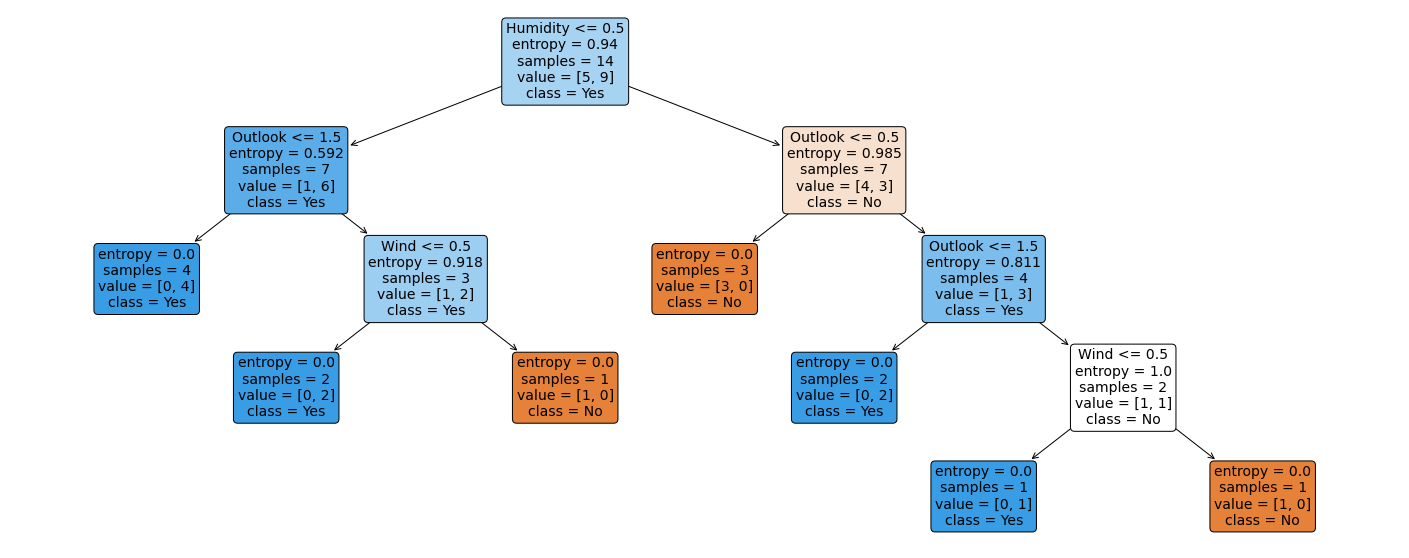

In [17]:
plt.figure(figsize=(25,10))
a = plot_tree(clf, 
              feature_names=columnNames, 
              class_names=['No','Yes'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

In [18]:
y_pred_sklearn =clf.predict(data[:,:4])

In [19]:
getErrorRate(y_pred_sklearn,data[:,4])

0.0